In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from typing import List, Dict

plt.ion()

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/home/viniciusandreossi/anaconda3/envs/cleanrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Solving the Lunar Lander Environment with Reinforce

<img src="media/lunar_lander.gif" width="200">

Important information for modeling the environment as a Markov Decision Process (MDP):

### Action Space

The action space is discrete and contains integers in the range {0, 3}. Each action represents a movement direction:
* 0: Do nothing
* 1: Fire left thruster
* 2: Fire main thruster
* 3: Fire right thruster

### State Space

The state vector has eight elements: x & y coordinates, x & y velocities, angle, rotational velocity, and two boolean variables indicating whether the spacecraft's legs are touching the ground.

### Rewards

At each time step, the reward:

* Increases/decreases if the spacecraft moves closer to/farther from the landing pad.
* Increases/decreases if the spacecraft moves slower/faster.
* Decreases as the spacecraft becomes more tilted.
* Increases by 10 points for each leg of the spacecraft touching the ground.
* Decreases by 0.03 points for each frame a lateral thruster is active.
* Decreases by 0.3 points for each frame the main thruster is active.

At the end of the episode, an additional reward of -100 or +100 is awarded depending on whether the spacecraft crashes or lands safely.

If the final score exceeds 200, the episode is considered solved.

## Creating the Policy Model

Reinforce is a policy gradient algorithm, meaning the neural network represents the policy itself and is used to calculate the probability of each action for a given state (rather than the value of each action, as in value-based methods).

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64], n_actions=4):
        super().__init__()

        # build neural network
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, n_actions))
        layers.append(nn.Softmax(dim=-1))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

## Sampling Actions from the Policy Neural Network

One advantage of replacing the policy with a neural network is that the learned optimal policy is inherently stochastic, whereas deterministic policies are a limiting case where one action has an infinitely higher probability than the others. Furthermore, the fact that the policy is naturally stochastic allows the model to explore the environment more effectively during learning.

Reinforce uses the logarithm of the probability of the chosen action to calculate the loss function, so storing this value during inference makes the algorithm more efficient.

In [3]:
def get_action(policy: PolicyNet, state):
    probs = policy(torch.tensor([state]).to(DEVICE))
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action) 

## Choosing a Baseline

The Reinforce loss function allows any function that depends only on the state to be subtracted from the expected return for the step. This function is called the _baseline_, and the estimated state value is a common choice for this role, as it reduces the variance of weight updates without changing the average value. This property leads to greater stability during training.

Similar to Q-Learning, the estimated value function can be learned through regression using a neural network.

In [4]:
class ValueBaseline(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64]):
        super().__init__()

        # build neural network
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, 1))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

## Training the Neural Networks

Reinforce is a Monte Carlo and _on-policy_ algorithm, so it involves sampling an entire trajectory to take a learning step. A trajectory is defined as the entire sequence of steps from an initial state to a final state. After sampling a trajectory, the observed return for each step in the trajectory is calculated using the following formula:

$$G_t = \sum_{k=t+1}^T \gamma^{k-t-1}R_k$$

and the difference between the observed return and the expected return (without calculating gradients):

$$\delta = G_t - \hat{v}(s; \theta)$$

Then, for each step, the weights of the policy ($w$) and value function ($\theta$) are updated according to the following rules:

$$w \leftarrow w + \alpha_w \delta \nabla \hat{v}(s;w)$$
$$\theta \leftarrow \theta + \alpha_\theta \gamma^t \delta \nabla \ln{\pi(A_t|s; \theta)}$$

where $A_t$ is the action taken at step $t$.

In [5]:
def update_policy_net(
    policy: PolicyNet, 
    value: ValueBaseline,
    ep_rewards,
    logprobs,
    states,
    policy_optimizer: torch.optim.Optimizer, 
    value_optimizer: torch.optim.Optimizer,
    gamma,
    normalize_rewards=False):

    if len(ep_rewards) != len(logprobs):
        raise ValueError("Rewards and logprobs buffers must have the same length")
    
    # calculating and normalizing the discounted total reward for each step
    rewards = torch.tensor([step_reward for step_reward in ep_rewards], dtype=torch.float32, device=DEVICE)
    discounts = gamma ** torch.arange(len(rewards), device=DEVICE)
    discounted_rewards = rewards * discounts
    cumsum_rewards = discounted_rewards - discounted_rewards.cumsum(dim=-1) + discounted_rewards.sum(dim=-1)
    returns = cumsum_rewards / discounts

    if normalize_rewards:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # calculating the expected returns and their difference from the observed returns
    expected_returns = value(torch.cat(states)).squeeze()

    # value loss and value update
    value_loss = F.mse_loss(expected_returns, returns)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    # policy loss
    with torch.no_grad():
        delta = returns - expected_returns
    policy_loss = (- discounts * delta * torch.cat(logprobs)).sum(dim=-1)

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    return policy, value, policy_loss.item(), value_loss.item()

## Performance evaluation

In [13]:
def evaluate(metrics: Dict, show_result=False):
    rewards = torch.tensor(metrics['episode_rewards'])
    plt.figure(1)
    plt.clf
    plt.title('Total reward of each episode')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.grid()
    plt.plot(rewards)

    # Take 100 episode averages and plot them too
    if metrics['avg_reward'] is not None: 
        x = range(49, 49 + len(metrics['avg_reward']))
        plt.plot(x, metrics['avg_reward'].numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated

    # plotting losses
    fig, ax1 = plt.subplots()
    plt.clf

    ax2 = ax1.twinx()
    ax1.plot(metrics['avg_policy_loss_on_ep'], color= 'green')
    ax2.plot(metrics['avg_value_loss_on_ep'], color='blue')

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Policy loss', color='green')
    ax2.set_ylabel('Value loss', color='blue')

    ax1.grid()
    plt.title('Losses')
    plt.show()
    
    plt.pause(0.001)

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


## Training Loop

In the training loop, we will combine all the functions developed so far. The main idea is to define a maximum number of episodes (from the initial stage to the final stage) so that the agent collects experiences from the environment and optimizes its Q-value table.

In [7]:
def train(
        env: gym.Env, 
        policy: PolicyNet,
        baseline: ValueBaseline,
        n_episodes=10_000,
        ep_max_steps=1000,
        gamma=0.99,
        policy_lr=5e-4,
        baseline_lr=5e-4,
        verbose=False):
    
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=policy_lr)
    baseline_optimizer = torch.optim.Adam(baseline.parameters(), lr=baseline_lr)
    
    metrics = {
        'episode_rewards': [],
        'avg_reward': None,
        'avg_policy_loss_on_ep': [],
        'avg_value_loss_on_ep': [],
    }
    episode_step = 0
    truncated = False

    for episode in range(n_episodes):
        rewards = []
        logprobs = []
        states = []

        state, _ = env.reset()
        ep_reward = 0

        # observe
        for step in range(ep_max_steps):
            action, logprob = get_action(policy, state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            logprobs.append(logprob)
            states.append(torch.tensor([state]).to(DEVICE))
            ep_reward += reward

            if terminated or truncated:
                break
        
        # update policy
        policy, baseline, policy_loss, value_loss = update_policy_net(policy, baseline, rewards, logprobs, states, policy_optimizer, baseline_optimizer, gamma)

        # logging        
        if verbose:
            metrics['episode_rewards'].append(ep_reward)
            if len(metrics['episode_rewards']) > 50:
                metrics['avg_reward'] = torch.tensor(metrics['episode_rewards']).float().unfold(0, 50, 1).mean(1)
                print(f'avg reward: {metrics["avg_reward"][-1]}')

            metrics['avg_policy_loss_on_ep'].append(policy_loss)
            metrics['avg_value_loss_on_ep'].append(value_loss)

            evaluate(metrics)
        

    evaluate(metrics, show_result=True)
    return policy

## Training

Everything is set up, so now we can run the algorithm!

In [14]:
lunar_lander = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
policy_net = PolicyNet().to(DEVICE)
baseline = ValueBaseline().to(DEVICE)
trained_policy_net = train(lunar_lander, policy_net, baseline, policy_lr=1e-3, verbose=True)

avg reward: -77.18533325195312


KeyboardInterrupt: 

avg reward: -49.255584716796875


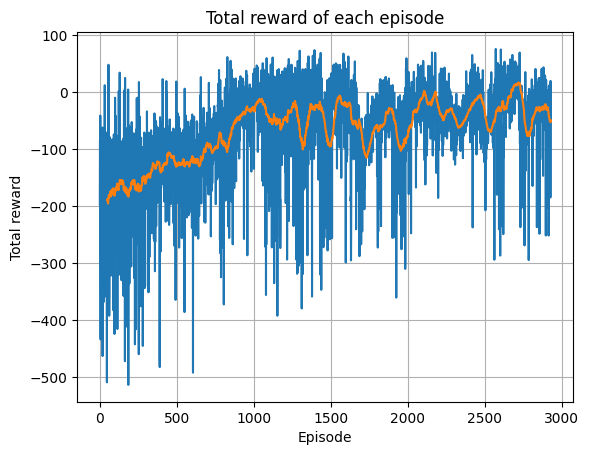

<Figure size 640x480 with 0 Axes>

In [ ]:
lunar_lander = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
policy_net = PolicyNet()
baseline = ValueBaseline()
trained_policy_net = train(lunar_lander, policy_net, baseline, verbose=True)

## Testing the agent

The function below will run an episode with the trained agent.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    total_reward = torch.tensor(total_rewards, dtype=torch.float32)
    return torch.mean(total_reward)

test(gym.make('LunarLander-v2', render_mode="human"), trained_q_net)

tensor(261.2986)

## Exercise - Non-Deterministic Environments
Now that we have seen the agent learn a path to the goal that minimizes the distance walked and avoids the cliff, it's time to make things a bit more challenging. We will now use a modified version of Cliff Walking that adds random wind toward the cliff. In other words, there is a probability that the agent will be involuntarily displaced one step down.

This change will be interesting for observing the influence of the learning rate on training a model robust to non-deterministic environments.

In [ ]:
nd_lunar_lander = gym.make('LunarLander-v2', enable_wind=True, render_mode="human")
nd_q_net = Qnet()
trained_nd_q_net = train(nd_lunar_lander, nd_q_net, total_steps=450_000, epsilon_decay=100_000, learning_rate=5e-4, replay_buffer_size=2 ** 20, batch_size=128, verbose=True)

NameError: name 'Qnet' is not defined